In [1]:
import matplotlib
import tensorflow as tf
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import math

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/ANN&DL_Homework2
#!unzip training_dataset_homework2.zip

/content/drive/MyDrive/ANN&DL_Homework2


In [5]:
# Load the dataset
X = np.load('x_train.npy')
Y = np.load('y_train.npy')

In [6]:
X.shape, Y.shape

((2429, 36, 6), (2429,))

In [7]:
n_classes = len(np.unique(Y))
class_labels = np.unique(Y)
print("There are {} classes".format(n_classes))
print("The labels are: {}".format(class_labels))

There are 12 classes
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [8]:
# Count the number of samples in each class
class_labels_count = []
for label in class_labels:
  class_labels_count.append(sum([1 if Y[i]==label else 0 for i in range(Y.shape[0])]))

for i in range(len(class_labels)):
  print("For label {} there are {} samples".format(class_labels[i], class_labels_count[i]))

For label 0 there are 34 samples
For label 1 there are 123 samples
For label 2 there are 270 samples
For label 3 there are 381 samples
For label 4 there are 62 samples
For label 5 there are 153 samples
For label 6 there are 313 samples
For label 7 there are 68 samples
For label 8 there are 120 samples
For label 9 there are 777 samples
For label 10 there are 77 samples
For label 11 there are 51 samples


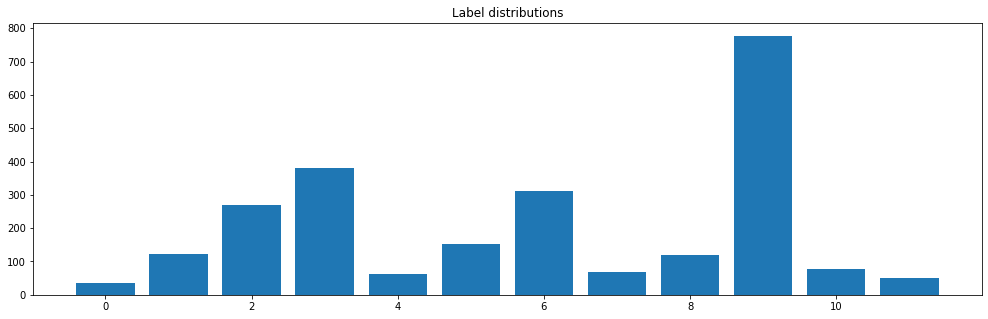

In [9]:
# Inspect label distribution
plt.figure(figsize=(17,5))
plt.bar(x=class_labels, height=class_labels_count)
plt.title('Label distributions')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# Split the data in train,val and test set
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.21, shuffle=True, random_state=seed, stratify=Y)
X_train , X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.1, shuffle=True, random_state=seed, stratify=Y_train_val)

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape

((1726, 36, 6), (192, 36, 6), (511, 36, 6), (1726,), (192,), (511,))

In [13]:
# Convert the sparse labels to categorical values
if len(Y_train.shape) < 2:  # avoid doing it twice
    Y_train_val = tfk.utils.to_categorical(Y_train_val)
    Y_train = tfk.utils.to_categorical(Y_train)
    Y_val = tfk.utils.to_categorical(Y_val)
    Y_test = tfk.utils.to_categorical(Y_test)

Y_train.shape, Y_val.shape, Y_test.shape

((1726, 12), (192, 12), (511, 12))

In [14]:
X_train_by_label = {}
for i in range(n_classes):
    X_train_by_label[i] = X_train[Y_train[:, i] == True]

In [ ]:
fig,ax = plt.subplots(n_classes, 6, figsize=(30, n_classes*2))
for cl in range(n_classes):
    for f in range(6):
        ax[cl, f].plot(X_train_by_label[cl][0,:,f], color='blue')

In [17]:
def create_sliding(data, window_size):
    """
    Method that given the data in input, divide it according to the window size
      creating different smaller datasets
    """
    out = np.lib.stride_tricks.sliding_window_view(data, window_size, axis=1)
    out = np.moveaxis(out, 3, 1)
    return out

In [18]:
# Setting the window size to 30
w_size = 30
X_train_sliding = create_sliding(X_train, w_size)
X_val_sliding = create_sliding(X_val, w_size)

X_train_sliding.shape, X_train_sliding[:, :, 0, :].shape

((1726, 30, 7, 6), (1726, 30, 6))

In [19]:
def fit_model(train_data, train_labels, val_data, val_labels):
    input_shape = train_data.shape[1:]
    classes = train_labels.shape[-1]
    batch_size = 128
    epochs = 300

    # Define the model
    model = tfk.Sequential([
        tfkl.Input(shape=input_shape),
        tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True)),
        tfkl.Bidirectional(tfkl.LSTM(128)),
        tfkl.Dense(128, activation='relu'),
        tfkl.Dropout(.5, seed=seed),
        tfkl.Dense(classes, activation='softmax')
    ])

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    #model.summary()

    model.fit(
        x = train_data,
        y = train_labels,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(val_data, val_labels),
        verbose=0,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
        ]
    )

    return model

In [20]:
def eval_model(model):
    # Predict the test set
    predictions = model.predict(X_test)

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(Y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

In [ ]:
from tqdm import tqdm

# This code is for finding the best window size

'''
best_accuracy = 0.0
best_prediction = []
best_models = {}


for window in range(2, 36, 2):
  print("Windows is {}".format(window))
  w_size = window
  X_train_sliding = create_sliding(X_train, w_size)
  X_val_sliding = create_sliding(X_val, w_size)

  X_train_sliding.shape, X_train_sliding[:, :, 0, :].shape

  models = {}

  print("Training the models")
  for w in tqdm(range(X_train.shape[1] - w_size + 1)):
      X_train_w = X_train_sliding[:, :, w, :]
      X_val_w = X_val_sliding[:, :, w, :]
      models[w] = fit_model(X_train_w, Y_train, X_val_w, Y_val)

  X_test_sliding = create_sliding(X_test, w_size)
  preds = {}
  accuracies = {}
  for w in range(X_test.shape[1] - w_size + 1):
    preds[w] = models[w].predict(X_test_sliding[:,:,w,:])
    accuracies[w] = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(preds[w], axis=-1))

  pred = np.asarray(list(preds.values()))
  acc = np.asarray(list(accuracies.values()))

  pred_ens = np.average(pred, weights=acc, axis=0)
  accuracy=accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(pred_ens, axis=-1))

  print("The current accuracy is {}".format(round(accuracy, 4)))
  print("The best accuracy is {}".format(round(best_accuracy, 4)))

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_prediction = pred_ens
    best_models = models
'''

In [23]:
models = {}

print("Training the models")
for w in tqdm(range(X_train.shape[1] - w_size + 1)):
    X_train_w = X_train_sliding[:, :, w, :]
    X_val_w = X_val_sliding[:, :, w, :]
    # Fit a model for each dataset 
    models[w] = fit_model(X_train_w, Y_train, X_val_w, Y_val)

Training the models


100%|██████████| 7/7 [26:30<00:00, 227.28s/it]


In [24]:
models

{0: <keras.engine.sequential.Sequential at 0x7efd9a3a8340>,
 1: <keras.engine.sequential.Sequential at 0x7efd8da8f700>,
 2: <keras.engine.sequential.Sequential at 0x7efd8fa6cc70>,
 3: <keras.engine.sequential.Sequential at 0x7efd8aa2ceb0>,
 4: <keras.engine.sequential.Sequential at 0x7efd8b217be0>,
 5: <keras.engine.sequential.Sequential at 0x7efd87ca2640>,
 6: <keras.engine.sequential.Sequential at 0x7efd837392b0>}

In [25]:
X_test_sliding = create_sliding(X_test, w_size)
preds = {}
accuracies = {}
for w in range(X_test.shape[1] - w_size + 1):
    # Make the predictions for each model
    preds[w] = models[w].predict(X_test_sliding[:,:,w,:])
    # Compute the accuracy of the model
    accuracies[w] = accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(preds[w], axis=-1))
    print('Window: ',w,' Accuracy:',accuracies[w].round(4))

16/16 [==============================] - 3s 69ms/step
Window:  0  Accuracy: 0.591
16/16 [==============================] - 3s 69ms/step
Window:  1  Accuracy: 0.6106
16/16 [==============================] - 3s 69ms/step
Window:  2  Accuracy: 0.5851
16/16 [==============================] - 3s 69ms/step
Window:  3  Accuracy: 0.6086
16/16 [==============================] - 3s 76ms/step
Window:  4  Accuracy: 0.6223
16/16 [==============================] - 3s 67ms/step
Window:  5  Accuracy: 0.6321
16/16 [==============================] - 3s 70ms/step
Window:  6  Accuracy: 0.638


In [26]:
np.asarray(list(preds.values())).shape, np.asarray(list(accuracies.values())).shape

((7, 511, 12), (7,))

In [27]:
pred = np.asarray(list(preds.values()))
acc = np.asarray(list(accuracies.values()))

In [28]:
# Ensamble the models using the accuracy as weights
pred_ens = np.average(pred, weights=acc, axis=0)
accuracy=accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(pred_ens, axis=-1))
print('Accuracy:',accuracy.round(4))

# Ensamble the models simply averaging them
pred_ens_nw = np.sum(pred, axis=0)
accuracy_nw=accuracy_score(np.argmax(Y_test, axis=-1), np.argmax(pred_ens_nw, axis=-1))
print('Accuracy (no weight):',accuracy_nw.round(4))

Accuracy: 0.6673
Accuracy (no weight): 0.6654


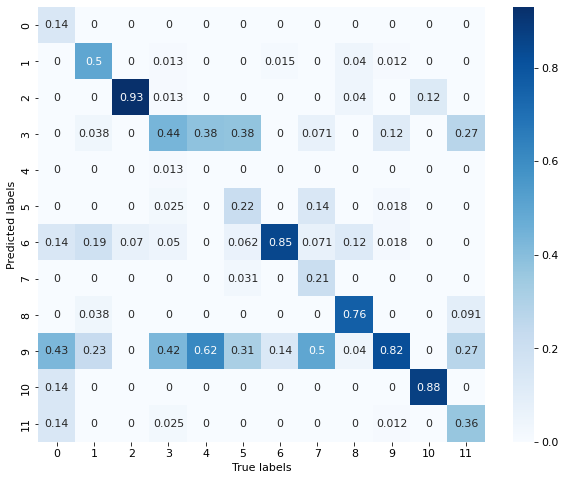

In [29]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(Y_test, axis=-1), np.argmax(pred_ens_nw, axis=-1), normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10,8))
plt.rc('font', size=11)
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(class_labels), yticklabels=list(class_labels), annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# Save the models
#for i, m in models.items():
#    m.save('SW_Models/'+str(i)+'/')